In [1]:
!pip install torch-summary --quiet
!pip install wandb --quiet
!pip install onnx --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 32.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.7/251.7 kB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 92.3 MB/s eta 0:00:00


In [2]:
import os
import gc
import json
import wandb
import signal
from datetime import datetime
import warnings
from tqdm import tqdm
from uuid import uuid4
import numpy as np
import matplotlib.pyplot as plt
import torch
from google.colab import drive
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import ImageFolder
from torchvision import transforms

import numpy as np
from sklearn.cluster import KMeans
import pandas as pd
from torch import nn
from torch import nn, optim
from torch.nn import Sequential, Conv2d, MaxPool2d, ReLU, BatchNorm2d, Dropout, CrossEntropyLoss, AdaptiveAvgPool2d, Flatten, Linear
from torchsummary import summary


if torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"

print(f"Device: {device}")


os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:1024"




Device: cuda


In [3]:
## Some constant variables
drive.mount('/content/drive')
CAPSTONE_PATH = "/content/drive/MyDrive/CMU/Fall 23/Capstone Project - Team Cylab/CapStone" # replace it with your path to the drive for capstone shared with you
DATA_ROOT_PATH = os.path.join(CAPSTONE_PATH, 'data')
CHECKPOINT_PATH = os.path.join(CAPSTONE_PATH, 'Checkpoints')


TRAIN_DIR = os.path.join(DATA_ROOT_PATH, 'SPLIT_DATA_WITH_OG', 'Train')
VALID_DIR = os.path.join(DATA_ROOT_PATH, 'SPLIT_DATA_WITH_OG', 'Valid')
TEST_DIR = os.path.join(DATA_ROOT_PATH, 'SPLIT_DATA_WITH_OG', 'Test')
FEATURE_EXTRACTOR_DIR = os.path.join(DATA_ROOT_PATH, 'SPLIT_DATA_WITH_OG', 'Feature_Extractor')


# Training
train_210_dir = os.path.join(DATA_ROOT_PATH, 'SPLIT_DATA_WITH_OG', 'Final_Experiment', 'Train', '210')


# Validation
valid_210_dir = os.path.join(DATA_ROOT_PATH, 'SPLIT_DATA_WITH_OG', 'Final_Experiment', 'Valid', '210')

# Testing
test_210_dir = os.path.join(DATA_ROOT_PATH, 'SPLIT_DATA_WITH_OG', 'Final_Experiment', 'Test', '210')
test_220_dir = os.path.join(DATA_ROOT_PATH, 'SPLIT_DATA_WITH_OG', 'Final_Experiment', 'Test', '220')
test_230_dir = os.path.join(DATA_ROOT_PATH, 'SPLIT_DATA_WITH_OG', 'Final_Experiment', 'Test', '230')
test_250_dir = os.path.join(DATA_ROOT_PATH, 'SPLIT_DATA_WITH_OG', 'Final_Experiment', 'Test', '250')
test_268_dir = os.path.join(DATA_ROOT_PATH, 'SPLIT_DATA_WITH_OG', 'Final_Experiment', 'Test', '268')


# Feature Extractor
feature_extractor_210_dir = os.path.join(DATA_ROOT_PATH, 'SPLIT_DATA_WITH_OG', 'Final_Experiment', 'Feature_Extractor', '210')
feature_extractor_220_dir = os.path.join(DATA_ROOT_PATH, 'SPLIT_DATA_WITH_OG', 'Final_Experiment', 'Feature_Extractor', '220')
feature_extractor_230_dir = os.path.join(DATA_ROOT_PATH, 'SPLIT_DATA_WITH_OG', 'Final_Experiment', 'Feature_Extractor', '230')
feature_extractor_250_dir = os.path.join(DATA_ROOT_PATH, 'SPLIT_DATA_WITH_OG', 'Final_Experiment', 'Feature_Extractor', '250')
feature_extractor_268_dir = os.path.join(DATA_ROOT_PATH, 'SPLIT_DATA_WITH_OG', 'Final_Experiment', 'Feature_Extractor', '268')

Mounted at /content/drive


In [4]:
# Class Label
TRAIN_LABELS = sorted(os.listdir(TRAIN_DIR))
VALID_LABELS = sorted(os.listdir(VALID_DIR))
TEST_LABELS = sorted(os.listdir(TEST_DIR))
FEATURE_EXTRACTOR_LABELS = sorted(os.listdir(FEATURE_EXTRACTOR_DIR))


# Training
TRAIN_LABELS_210 = sorted(os.listdir(train_210_dir))

# Validation
VALID_LABELS_210 = sorted(os.listdir(valid_210_dir))


# Testing
TEST_LABELS_210 = sorted(os.listdir(test_210_dir))
TEST_LABELS_220 = sorted(os.listdir(test_220_dir))
TEST_LABELS_230 = sorted(os.listdir(test_230_dir))
TEST_LABELS_250 = sorted(os.listdir(test_250_dir))
TEST_LABELS_268 = sorted(os.listdir(test_268_dir))

# Feature Extractor
FEATURE_EXTRACTOR_LABELS_210 = sorted(os.listdir(feature_extractor_210_dir))
FEATURE_EXTRACTOR_LABELS_220 = sorted(os.listdir(feature_extractor_220_dir))
FEATURE_EXTRACTOR_LABELS_230 = sorted(os.listdir(feature_extractor_230_dir))
FEATURE_EXTRACTOR_LABELS_250 = sorted(os.listdir(feature_extractor_250_dir))
FEATURE_EXTRACTOR_LABELS_268 = sorted(os.listdir(feature_extractor_268_dir))


In [5]:

# configurations
CONFIG = {
    "batch_size": 32,
    "num_classes": 210,
    "epochs": 30,
    "learning_rate": 2e-3,
    "momentum": 0.95,
    "weight_decay": 1e-4,
    "label_smoothing": 0.2,
    "scheduler_factor": 0.4,
    "min_lr": 1e-4,
    "scheduler_patience": 3,
    "scheduler_threshold": 0.05,
    'TEAM_MEMBER': 'Schadrack',
    'archetype': 'Resnet50',
    'optim': 'AdamW'
}

print(f"Configurations:\n")
for key, value in CONFIG.items():
  print(f"{key}: {value}\n")
print()

Configurations:

batch_size: 32

num_classes: 210

epochs: 30

learning_rate: 0.002

momentum: 0.95

weight_decay: 0.0001

label_smoothing: 0.2

scheduler_factor: 0.4

min_lr: 0.0001

scheduler_patience: 3

scheduler_threshold: 0.05

TEAM_MEMBER: Schadrack

archetype: Resnet50

optim: AdamW




In [6]:
# Loading data using torchvision datasets imagefolder
# data_mean = (0.5116, 0.4026, 0.3519)
# data_std = (0.3073, 0.2697, 0.2587)

data_mean = (0.485, 0.456, 0.406)
data_std = (0.229, 0.224, 0.225)

transformations = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=data_mean, std=data_std)
]
)  # converting to tensor and resizing all images to 256x256



train_data_210 = ImageFolder(root=train_210_dir, transform=transformations)
valid_data_210 = ImageFolder(root=valid_210_dir, transform=transformations)

test_data_210 = ImageFolder(root=test_210_dir, transform=transformations)
test_data_220 = ImageFolder(root=test_220_dir, transform=transformations)
test_data_230 = ImageFolder(root=test_230_dir, transform=transformations)
test_data_250 = ImageFolder(root=test_250_dir, transform=transformations)
test_data_268 = ImageFolder(root=test_268_dir, transform=transformations)

feature_extractor_data_210 = ImageFolder(root=feature_extractor_210_dir, transform=transformations)
feature_extractor_data_220 = ImageFolder(root=feature_extractor_220_dir, transform=transformations)
feature_extractor_data_230 = ImageFolder(root=feature_extractor_230_dir, transform=transformations)
feature_extractor_data_250 = ImageFolder(root=feature_extractor_250_dir, transform=transformations)
feature_extractor_data_268 = ImageFolder(root=feature_extractor_268_dir, transform=transformations)

In [7]:
# Data loaders
train_loader = DataLoader(train_data_210,
                         batch_size=CONFIG['batch_size'],
                         shuffle     = True,
                         num_workers = 2,
                         pin_memory  = True)


val_loader = DataLoader(valid_data_210,
                        batch_size=CONFIG['batch_size'],
                        shuffle     = False,
                        num_workers = 2,
                        pin_memory  = True)

val_loader_test = DataLoader(valid_data_210,
                        batch_size=CONFIG['batch_size'],
                        shuffle     = False,
                        num_workers = 2,
                        pin_memory  = True)


test_loader_210 = DataLoader(test_data_210,
                         batch_size=CONFIG['batch_size'],
                         shuffle     = False,
                         num_workers = 2,
                         pin_memory  = True)


test_loader_220 = DataLoader(test_data_220,
                         batch_size=CONFIG['batch_size'],
                         shuffle     = False,
                         num_workers = 2,
                         pin_memory  = True)


test_loader_230 = DataLoader(test_data_230,
                         batch_size=CONFIG['batch_size'],
                         shuffle     = False,
                         num_workers = 2,
                         pin_memory  = True)


test_loader_250 = DataLoader(test_data_250,
                         batch_size=CONFIG['batch_size'],
                         shuffle     = False,
                         num_workers = 2,
                         pin_memory  = True)


test_loader_268 = DataLoader(test_data_268,
                         batch_size=CONFIG['batch_size'],
                         shuffle     = False,
                         num_workers = 2,
                         pin_memory  = True)



##########################################################

feature_extractor_loader_210 = DataLoader(feature_extractor_data_210,
                         batch_size=CONFIG['batch_size'],
                         shuffle     = False,
                         num_workers = 2,
                         pin_memory = True)


feature_extractor_loader_220 = DataLoader(feature_extractor_data_220,
                         batch_size=CONFIG['batch_size'],
                         shuffle     = False,
                         num_workers = 2,
                         pin_memory = True)


feature_extractor_loader_230 = DataLoader(feature_extractor_data_230,
                         batch_size=CONFIG['batch_size'],
                         shuffle     = False,
                         num_workers = 2,
                         pin_memory = True)


feature_extractor_loader_250 = DataLoader(feature_extractor_data_250,
                         batch_size=CONFIG['batch_size'],
                         shuffle     = False,
                         num_workers = 2,
                         pin_memory = True)


feature_extractor_loader_268 = DataLoader(feature_extractor_data_268,
                         batch_size=CONFIG['batch_size'],
                         shuffle     = False,
                         num_workers = 2,
                         pin_memory = True)


In [8]:
def normalize_image_and_convert_to_pil(image):
  denormalize_image = transforms.Normalize(mean=[1/0.485, 1/0.456, 1/0.406], std=[1/0.229, 1/0.224, 1/0.225])(image)
  return np.array(transforms.ToPILImage()(denormalize_image))

In [9]:
def plot_pil_images(images, labels_names, labels_numbers, figsize: tuple=None):
    if len(images) == 0:
        raise ValueError("Images cannot be empty")

    rows = int(np.sqrt(len(images)))
    cols = len(images) // rows

    if cols > rows:  #  I want rows to be greater than cols
        temp = rows
        rows = cols
        cols = temp

    fig, axes = plt.subplots(nrows=rows, ncols=cols)
    if figsize and len(images)!=1:
        fig.set_size_inches(figsize[0], figsize[1])

    if len(images) == 1:
            axes.imshow(normalize_image_and_convert_to_pil(images[0]))
            axes.axis('off')
            axes.set_title(labels_names[0])

    elif len(images) < 3:
        for i in range(len(images)):
            axes[i].imshow(normalize_image_and_convert_to_pil(images[i]))
            axes[i].axis('off')
            axes[i].set_title(labels_names[i])
    else:
        count_image = 0
        for row in range(rows):
            for col in range(cols):
                axes[row, col].imshow(normalize_image_and_convert_to_pil(images[count_image]))
                axes[row, col].axis('off')
                axes[row, col].set_title(labels_names[count_image])
                count_image += 1

    plt.show()

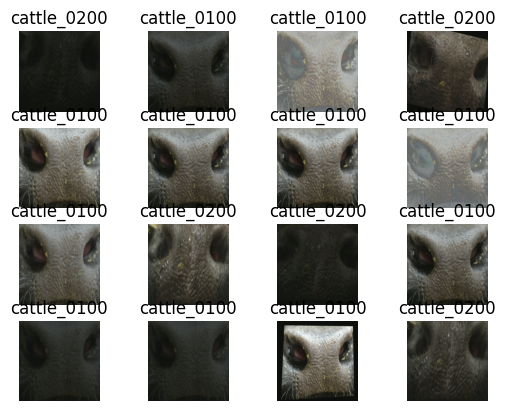

In [10]:
# Viewing random samples
sample_images_indicies = np.random.randint(0, len(val_loader_test), size=(16,))
sample_images, sample_lables = [], []
labels_num = []
for indx in sample_images_indicies:
  img, label = train_data_210[indx]
  sample_images.append(img)
  sample_lables.append(VALID_LABELS_210[label])
  labels_num.append(label)


# View sample images from train
plot_pil_images(sample_images, sample_lables, labels_num)

In [11]:
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.memory_summary(device=device, abbreviated=False)
# testing data loaders
for Xb, yb in val_loader_test:
  Xb, yb = Xb.to(device), yb.to(device)
  print(f"Images shape: {Xb.shape}")
  print(f"Labels shape: {yb.shape}")
  break


Images shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32])


#Resnet

In [12]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, expansion, identity_downsample = None, stride=1):
        super(Block, self).__init__()
        self.expansion = expansion
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, padding=0, stride=1)
        self.bn3 = nn.BatchNorm2d(out_channels*self.expansion)
        self.gelu = nn.GELU()
        self.identity_downsample = identity_downsample

    def forward(self, x):
        identity = x.clone()
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.gelu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.gelu(x)

        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.gelu(x)
        return x

In [13]:
class ResNet(nn.Module):
    def __init__(self, block, layers, image_channels, out_channels, expansion, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = image_channels
        self.conv1 = nn.Conv2d(self.in_channels, self.in_channels, kernel_size = 7, stride = 1, padding = 3) # output shape 224 -> When input shape is 224
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.gelu = nn.GELU()
        self.maxpool = nn.MaxPool2d(kernel_size=5, stride=3) # output shape 73x73


        # REsnet Layers
        self.layer1 = self._make_layer(block, layers[0], out_channels=out_channels, stride=1, expansion=expansion) # output 73
        self.layer2 = self._make_layer(block, layers[1], out_channels=out_channels * expansion//2, stride=2, expansion=expansion) # output 33
        self.layer3 = self._make_layer(block, layers[2], out_channels=out_channels * expansion, stride=2, expansion=expansion) # output 33
        self.layer4 = self._make_layer(block, layers[3], out_channels=out_channels * expansion * 2, stride=2, expansion=expansion) # output 33

        self.avgpool = nn.AdaptiveAvgPool2d((5, 5))

        self.fc = nn.Linear(out_channels * expansion * 2 * expansion * 5 * 5, num_classes)

    def forward(self, x, return_features=False):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.gelu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1) # Reshaping before sending to the fully connected layer

        if return_features:
          return x

        x = self.fc(x)

        return x

    def _make_layer(self, block, num_residual_blocks, out_channels, stride, expansion):
        identity_downsample = None
        layers = []

        if stride != 1 or self.in_channels != out_channels * expansion:
            identity_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * expansion, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels * expansion)
            )

        layers.append(block(self.in_channels, out_channels, expansion, identity_downsample, stride))
        self.in_channels = out_channels * expansion

        for i in range(1, num_residual_blocks):
            layers.append(block(self.in_channels, out_channels, expansion))

        return nn.Sequential(*layers)

In [14]:
class Resnet50(ResNet):
    def __init__(self, block, image_channels, out_channels, expansion, num_classes):
        super(Resnet50, self).__init__(block, [3, 4, 6, 3], image_channels, out_channels, expansion, num_classes)
        self.database = {} # keeps class with its corresponding features which will be used for dot product predictions

    def train_model(self, optimizer, dataloader, criterion, scaler, device='cpu'):
        self.train() # put the model into train mode
        total_batches = len(dataloader)
        num_correct = 0
        train_acc = 0
        total_loss = 0
        total_images = 0 # images model has already seen
        batch_bar = tqdm(total=total_batches, dynamic_ncols=True, leave=False, position=0, desc='Train', ncols=5)

        for index, (images, labels) in enumerate(dataloader):
            images, labels = images.to(device), labels.to(device) # moving data to same device with the model
            total_images += len(images)
            optimizer.zero_grad() # zeroing the previous gradients
            with torch.cuda.amp.autocast(): # allowing mixed precission during forward propagation
                logits = self(images) # forward pass
                loss = criterion(logits, labels) # calculating the loss/divergence

            # Find number of correct predictions and add them to previous correct total of predictions
            num_correct += int((torch.argmax(logits, axis=1) == labels).sum()) # make summation and cast it to integer
            train_acc = num_correct * 100 / total_images
            total_loss += float(loss.item()) # find the loss

            # Adding monitoring data to tqdm bar
            batch_bar.set_postfix(
                train_acc="{:.04f}%".format(train_acc),
                train_loss="{:.04f}".format(total_loss / (index + 1)),
                correct_preds="{}".format(num_correct),
                lr="{:.04f}".format(optimizer.param_groups[0]['lr'])
            )

            batch_bar.update()

            # Backward pass
            scaler.scale(loss).backward()

            # Gradient descent to update parameter
            scaler.step(optimizer)
            scaler.update()

            # Release some memory
            del images, labels, logits

            if torch.cuda.is_available():
                torch.cuda.empty_cache()

        batch_bar.close()
        total_loss /= total_batches

        return train_acc, total_loss


    def validate_model(self, dataloader, criterion, device='cpu'):
        self.eval() # put the model into evaluation mode
        total_batches = len(dataloader)
        num_correct = 0
        val_acc = 0
        val_loss = 0
        total_images = 0 # images model has already seen
        batch_bar = tqdm(total=total_batches, dynamic_ncols=True, leave=False, position=0, desc='Validation', ncols=5)

        for index, (images, labels) in enumerate(dataloader):
            images, labels = images.to(device), labels.to(device)
            total_images += len(images)
            with torch.inference_mode(): # inferring
                logits = self(images) # forward pass
                loss = criterion(logits, labels) # Loss calculation

            num_correct += int((torch.argmax(logits, axis=1) == labels).sum())
            val_acc = num_correct * 100 / total_images
            val_loss = loss.item()

            # Adding monitoring data to tqdm bar
            batch_bar.set_postfix(
                train_acc="{:.04f}%".format(val_acc),
                train_loss="{:.04f}".format(val_loss / (index + 1)),
                correct_preds="{}".format(num_correct)
            )

            batch_bar.update()

            del images, labels, logits

            if torch.cuda.is_available():
                torch.cuda.empty_cache()

        batch_bar.close()
        val_loss /= total_batches

        return val_acc, val_loss


    def predict_with_classifier(self, dataloader, device='cpu', labels_names=None):
        self.eval() # put the model into evaluation mode
        batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Classifier Predict', ncols=5)
        prediction_results = []
        for index, images in enumerate(dataloader):
            if type(images) in [tuple, list]:
              images = images[0]
            images = images.to(device)
            with torch.inference_mode():
                logits = self(images)

            # detaching the from the computational graph and convert result to list
            logits = torch.argmax(logits, axis=1).detach().cpu().numpy().tolist()
            prediction_results.extend(logits)

            batch_bar.update()
            del logits

            if torch.cuda.is_available():
                torch.cuda.empty_cache()

        batch_bar.close()

        if labels_names: # return predicted class names
            predicted_classes = []
            for prediction in prediction_results:
              predicted_classes.append(labels_names[prediction])

            return prediction_results, predicted_classes

        return prediction_results



    def extract_best_features_by_clustering(self, features):
        # Apply Clustering Algorithm
        n_clusters = 5 # The number of clusters, because we need one D
        cluster_model = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
        cluster_model.fit(features)

        # Obtain Cluster Representations
        cluster_assignments = cluster_model.predict(features)
        cluster_centers = cluster_model.cluster_centers_

        # Generate Final Feature Vector
        # final_feature_vector = np.concatenate(cluster_centers, axis=0)  # Concatenate cluster centers

        return torch.tensor(cluster_centers.mean(axis=0))


    def extract_features(self, dataloader, label_names, extractor_func='mean', device='cpu'):
        """
        This method extracts the features and keeps them in the self.database
        These features will be used for making predictions with dot product
        params:
          extractor_func: this is a function to be use for either everaging or choosing the mean
        """
        self.eval()  # put the model into evaluation mode

        for label_name in label_names: # Removing the existing classes in database
            self.drop_class(label_name, False)

        batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Features Extractor', ncols=5)
        for images, labels in dataloader:
            images = images.to(device) # return features
            with torch.inference_mode():
                features_batch = self(images, return_features=True)

            # detaching the from the computational graph and convert result to list
            features_batch = features_batch.detach().cpu().numpy().tolist()
            for features, actual_label in zip(features_batch, labels.cpu().numpy().tolist()):
                    if label_names[actual_label] in label_names:
                        self.database[label_names[actual_label]] = self.database.get(label_names[actual_label], []) + [features]


            batch_bar.update()

            del features
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

        batch_bar.close()
        # Taking the average of features accross each image
        message = extractor_func.lower().capitalize() + " Features" if extractor_func.lower()!= "mean" else "Averaging Features"
        batch_bar = tqdm(total=len(self.database), dynamic_ncols=True, leave=False, position=0, desc=message, ncols=5)
        for key, value in self.database.items():
            if key in label_names:
                if extractor_func.lower() == 'median':
                    self.database[key] = torch.median(torch.tensor(value).to(device=device), axis=0).values
                elif extractor_func.lower() == 'clustering':
                    self.database[key] = self.extract_best_features_by_clustering(torch.tensor(value).to(device=device).detach().cpu().numpy()).to(device)
                else:
                    self.database[key] = torch.mean(torch.tensor(value).to(device=device), axis=0)

            batch_bar.update()

            del key, value

            if torch.cuda.is_available():
                torch.cuda.empty_cache()

        batch_bar.close()


    def predict_with_dot_product(self, dataloader, device='cpu'):
        self.eval() # put the model into evaluation mode
        batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Dot Product Predict', ncols=5)
        prediction_results = []
        values = list(model.database.values())
        database_features = torch.cat(values, dim=0).view(-1, len(values[0]))
        database_labels = list(self.database.keys())

        del values

        for index, images in enumerate(dataloader):
            if type(images) in [tuple, list]:
              images = images[0]
            images = images.to(device)
            with torch.inference_mode():
                features = self(images, return_features=True)

            # detaching the from the computational graph and convert result to list
            database_features = database_features.to(dtype=images.dtype)
            logits = database_features @ features.T
            logits = torch.argmax(logits, axis=0).detach().cpu().numpy().tolist()
            prediction_results.extend(logits)

            batch_bar.update()
            del logits

            if torch.cuda.is_available():
                torch.cuda.empty_cache()

        batch_bar.close()

        predicted_classes = []
        for prediction in prediction_results:
            predicted_classes.append(database_labels[prediction])

        del prediction_results

        return predicted_classes


    def get_database_len(self):
      return len(list(self.database.keys()))


    def get_database_classes(self):
      return list(self.database.keys())


    def get_database(self):
      return self.database


    def drop_class(self, class_name, print_msg=True):
      if self.database.get(class_name, None) is not None:
          del self.database[class_name]
      else:
        if print_msg:
            print(f"\nClass {class_name}\n")

In [15]:
# Function for setting the states checkpoints
def save_checkpoint(path, model, optimizer, train_acc, train_loss, valid_acc, valid_loss, epoch, learning_rate, scheduler=None):
    """
        Function saves different objects states
        args:
            model: the model to be saved
            optimizer: The optimizer to be saved
            epoch -> int: The epoch to be saved
            learning_rate -> decimal: The learning rate to be save
            scheduler: the scheduler to be saved
    """
    checkpoint = {
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "epoch": epoch,
        "learning_rate": learning_rate,
        "train_acc": train_acc,
        "train_loss": train_loss,
        "valid_acc": valid_acc,
        "valid_loss": valid_loss,
        "database": model.database
    }

    if scheduler:
        checkpoint["scheduler_state"] = scheduler.state_dict()

    torch.save(checkpoint, path)


# Function for loading checkpoint
def load_checkpoint(path, model, optimizer, scheduler=None, device='cpu'):
    checkpoint = torch.load(path, map_location=device)

    model.load_state_dict(checkpoint["model_state"])
    optimizer.load_state_dict(checkpoint["optimizer_state"])
    epoch = checkpoint["epoch"]
    learning_rate = checkpoint["learning_rate"]
    train_acc = checkpoint["train_acc"]
    train_loss = checkpoint["train_loss"]
    valid_acc = checkpoint["valid_acc"]
    valid_loss = checkpoint["valid_loss"]
    database = checkpoint["database"]

    model.database = database

    if scheduler:
        scheduler.load_state_dict(checkpoint["scheduler_state"])
        return model, optimizer, scheduler, learning_rate, epoch, train_acc, train_loss, valid_acc, valid_loss
    else:
        return model, optimizer, scheduler, learning_rate, epoch, train_acc, train_loss, valid_acc, valid_loss



# Function for setting the states checkpoints
def save_model_checkpoint(path, model, device='cpu'):
    """
        Function saves  model state
        args:
            model: the model to be saved
    """
    checkpoint = torch.load(path, map_location=device)
    checkpoint["model_state"] = model.state_dict()
    checkpoint["database"] = model.database

    torch.save(checkpoint, path)

# function which loads only the model
def load_model_checkpoint(path, model):
    checkpoint = torch.load(path, map_location=device)

    model.load_state_dict(checkpoint["model_state"])
    database = checkpoint["database"]

    model.database = database

    return model

In [16]:
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.memory_summary(device=device, abbreviated=False)

# Tesing the model creation
model = Resnet50(Block, Xb.shape[1], 62, 4, CONFIG["num_classes"]).to(device)

summary(model, Xb.shape[1:])

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 3, 224, 224]         444
├─BatchNorm2d: 1-2                       [-1, 3, 224, 224]         6
├─GELU: 1-3                              [-1, 3, 224, 224]         --
├─MaxPool2d: 1-4                         [-1, 3, 74, 74]           --
├─Sequential: 1-5                        [-1, 248, 74, 74]         --
|    └─Block: 2-1                        [-1, 248, 74, 74]         --
|    |    └─Conv2d: 3-1                  [-1, 62, 74, 74]          248
|    |    └─BatchNorm2d: 3-2             [-1, 62, 74, 74]          124
|    |    └─GELU: 3-3                    [-1, 62, 74, 74]          --
|    |    └─Conv2d: 3-4                  [-1, 62, 74, 74]          34,658
|    |    └─BatchNorm2d: 3-5             [-1, 62, 74, 74]          124
|    |    └─GELU: 3-6                    [-1, 62, 74, 74]          --
|    |    └─Conv2d: 3-7                  [-1, 248, 74, 74]         15,624
|   

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 3, 224, 224]         444
├─BatchNorm2d: 1-2                       [-1, 3, 224, 224]         6
├─GELU: 1-3                              [-1, 3, 224, 224]         --
├─MaxPool2d: 1-4                         [-1, 3, 74, 74]           --
├─Sequential: 1-5                        [-1, 248, 74, 74]         --
|    └─Block: 2-1                        [-1, 248, 74, 74]         --
|    |    └─Conv2d: 3-1                  [-1, 62, 74, 74]          248
|    |    └─BatchNorm2d: 3-2             [-1, 62, 74, 74]          124
|    |    └─GELU: 3-3                    [-1, 62, 74, 74]          --
|    |    └─Conv2d: 3-4                  [-1, 62, 74, 74]          34,658
|    |    └─BatchNorm2d: 3-5             [-1, 62, 74, 74]          124
|    |    └─GELU: 3-6                    [-1, 62, 74, 74]          --
|    |    └─Conv2d: 3-7                  [-1, 248, 74, 74]         15,624
|   

# Setting up optimizer, schedulers, scalers and loss function

In [17]:
# defining optimizer
optimizer = optim.AdamW(model.parameters(),
                      lr=CONFIG['learning_rate'],
                      # momentum=CONFIG['momentum'],
                      weight_decay=CONFIG['weight_decay'])

# loss function
criterion = nn.CrossEntropyLoss(label_smoothing=CONFIG['label_smoothing'])

# scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                 mode='max',
                                                 factor= CONFIG['scheduler_factor'],
                                                 patience=CONFIG['scheduler_patience'],
                                                 min_lr=CONFIG['min_lr'],
                                                threshold=CONFIG['scheduler_threshold'])
# Defining scaler
scaler = torch.cuda.amp.GradScaler()

# Wandb Set up

In [18]:
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.memory_summary(device=device, abbreviated=False)

# Use wandb? Resume Training?
USE_WANDB = True
# RESUME_LOGGING = False
RESUME_LOGGING = False

# Create your wandb run
if RESUME_LOGGING:
    run_id = None  # Your run id here, uncomment
    if run_id is None:
        print("You need to enter run_id, check the previous run name")
        os.kill(os.getpid(), signal.SIGINT) # stop the cell
else:
    run_id = uuid4()

run_name = '{}_V2_Arc_{}__Optim_{}_{}_210'.format(
    CONFIG['TEAM_MEMBER'],
    CONFIG['archetype'],
    CONFIG['optim'],
    run_id,
)

if USE_WANDB:

    wandb.login(key="f5bd12ab0c50d70754bf684058b58b161e17bfd9")

    if RESUME_LOGGING:
        if run_id is None:  # check run_id in the run_name
            print("You need to enter run_id, check the previous run name")
            os.kill(os.getpid(), signal.SIGINT) # stop the cell
        run = wandb.init(
            id     = run_id, ### Insert specific run id here if you want to resume a previous run
            resume = "must", ### You need this to resume previous runs, but comment out reinit = True when using this
            project = "Capstone-CyLab-AB", ### Project should be created in your wandb account
        )
    else:
        run = wandb.init(
            name    = run_name, ### Wandb creates random run names if you skip this field, we recommend you give useful names
            reinit  = True, ### Allows reinitalizing runs when you re-run this cell
            project = "Capstone-CyLab-AB", ### Project should be created in your wandb account
            config  = CONFIG ### Wandb Config for your run
        )

        ### Save your model architecture as a string with str(model)

        model_arch  = str(model)

        ### Save it in a txt file
        arch_file   = open("model_arch_210.txt", "w")
        file_write  = arch_file.write(model_arch)
        arch_file.close()

        ### log it in your wandb run with wandb.save()
        wandb.save('model_arch_210.txt')

        ## Save Model Architecture as ONNX

        torch.onnx.export(model,     # model being run
            Xb.to(device),  # model input (or a tuple for multiple inputs)
            "model_210.onnx",       # where to save the model
            export_params=True,  # store the trained parameter weights inside the model file
            opset_version=10,    # the ONNX version to export the model to
            do_constant_folding=True,  # whether to execute constant folding for optimization
            input_names = ['Cattle_Muzzle_print_images'],   # the model's input names
            output_names = ['Cattle_name_identifier'], # the model's output names
        )
        wandb.save("model_210.onnx")

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: nschadrack1998 (cylab). Use `wandb login --relogin` to force relogin


<ipython-input-13-90b0b28efc8d>:35: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if return_features:


# Running Experiments

In [19]:
checkpoint_name = "{}_best_checkpoint_{}_210.pth".format(CONFIG['TEAM_MEMBER'], CONFIG['archetype'])
checkpoint_path = os.path.join(CHECKPOINT_PATH, checkpoint_name)
experiments_logs_path = os.path.join(CAPSTONE_PATH, 'Experiments', CONFIG['TEAM_MEMBER'])



os.makedirs(experiments_logs_path, exist_ok = True)

In [20]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()

gc.collect()

best_valid_acc = 0
e = 0
epoch_time_ellapse = {}

wandb.watch(model, log="all")


if RESUME_LOGGING:
    (model, optimizer, scheduler, curr_lr, e,
     train_acc, train_loss, best_valid_acc, valid_loss) = load_checkpoint(checkpoint_path, model, optimizer, scheduler, device)

    print("""Resuming from epoch {} with \ntrain acc: {:.04f}% val acc: {:.04f}% train loss: {:.04f}
    valid loss: {:.04f} lr: {:.04f}\n Optimizer: """.format(e, train_acc, best_valid_acc, train_loss, valid_loss, curr_lr, optimizer))


if torch.cuda.is_available():
    torch.cuda.empty_cache()

gc.collect()

if e == CONFIG["epochs"]:
    CONFIG["epochs"] += 5


with open(f'{experiments_logs_path}/experiment_log_210.txt', "w") as f:
    for epoch in range(e, CONFIG["epochs"] + 1):
        epoch_start_time = datetime.now()

        epoch_line = "\nEpoch {}/{}".format(epoch+1, CONFIG['epochs'])
        print(epoch_line)

        curr_lr                 = float(optimizer.param_groups[0]['lr'])
        train_acc, train_loss = model.train_model(optimizer, train_loader, criterion, scaler, device)

        val_acc, val_loss     = model.validate_model(val_loader, criterion, device)


        epoch_line += "\tTrain Acc {:.04f}%\tTrain Loss {:.04f}\t Learning Rate {:.07f}".format(train_acc, train_loss, curr_lr)
        epoch_line += "\tVal Acc {:.04f}%\tVal Loss {:.04f}".format(val_acc, val_loss)
        print(epoch_line)


        if scheduler is not None:
            scheduler.step(val_acc)

        wandb.log({'train_acc': train_acc, 'train_loss': train_loss,
                  'val_acc': val_acc, 'valid_loss': val_loss, 'lr': curr_lr})

        if val_acc > best_valid_acc:
            best_valid_acc = val_acc
            model_artifact = wandb.Artifact("model_checkpoint_210", type="model")
            save_checkpoint(checkpoint_path, model, optimizer, train_acc, train_loss, val_acc, val_loss, epoch, curr_lr, scheduler)


            print("\nSaved the best model\n")
            epoch_line += "\nSaved the best model\n"

        time_epoch_took = (datetime.now() - epoch_start_time).seconds
        print(f"Epoch {epoch + 1} took: {time_epoch_took // 60} minutes and {time_epoch_took % 60 } seconds")
        epoch_line += f"Epoch {epoch + 1} took: {time_epoch_took // 60} minutes and {time_epoch_took % 60 } seconds"

        epoch_time_ellapse[epoch] = time_epoch_took
        f.writelines(epoch_line)

    f.close()


with open(f'{experiments_logs_path}/epoch_time_ellapse_210.json', 'w') as f:
    json.dump(epoch_time_ellapse, f)
    f.close()

print(f"Best Validation Accuracy: {best_valid_acc}")


Epoch 1/30



Epoch 1/30	Train Acc 1.4286%	Train Loss 7.2628	 Learning Rate 0.0020000	Val Acc 5.0000%	Val Loss 0.0961

Saved the best model

Epoch 1 took: 64 minutes and 44 seconds

Epoch 2/30



Epoch 2/30	Train Acc 7.2043%	Train Loss 5.1768	 Learning Rate 0.0020000	Val Acc 15.5952%	Val Loss 0.0811

Saved the best model

Epoch 2 took: 1 minutes and 47 seconds

Epoch 3/30



Epoch 3/30	Train Acc 48.7097%	Train Loss 3.4711	 Learning Rate 0.0020000	Val Acc 66.8452%	Val Loss 0.0535

Saved the best model

Epoch 3 took: 1 minutes and 48 seconds

Epoch 4/30



Epoch 4/30	Train Acc 83.3794%	Train Loss 2.4161	 Learning Rate 0.0020000	Val Acc 87.1429%	Val Loss 0.0412

Saved the best model

Epoch 4 took: 1 minutes and 48 seconds

Epoch 5/30



Epoch 5/30	Train Acc 94.8080%	Train Loss 2.0601	 Learning Rate 0.0020000	Val Acc 82.9762%	Val Loss 0.0486
Epoch 5 took: 1 minutes and 47 seconds

Epoch 6/30



Epoch 6/30	Train Acc 97.2504%	Train Loss 1.9297	 Learning Rate 0.0020000	Val Acc 92.9167%	Val Loss 0.0382

Saved the best model

Epoch 6 took: 1 minutes and 48 seconds

Epoch 7/30



Epoch 7/30	Train Acc 98.7404%	Train Loss 1.8559	 Learning Rate 0.0020000	Val Acc 83.9286%	Val Loss 0.0483
Epoch 7 took: 1 minutes and 47 seconds

Epoch 8/30



Epoch 8/30	Train Acc 99.2012%	Train Loss 1.8153	 Learning Rate 0.0020000	Val Acc 92.7976%	Val Loss 0.0394
Epoch 8 took: 1 minutes and 47 seconds

Epoch 9/30



Epoch 9/30	Train Acc 98.0952%	Train Loss 1.8926	 Learning Rate 0.0020000	Val Acc 94.2262%	Val Loss 0.0376

Saved the best model

Epoch 9 took: 1 minutes and 48 seconds

Epoch 10/30



Epoch 10/30	Train Acc 99.0937%	Train Loss 1.8024	 Learning Rate 0.0020000	Val Acc 94.1667%	Val Loss 0.0366
Epoch 10 took: 1 minutes and 47 seconds

Epoch 11/30



Epoch 11/30	Train Acc 99.7542%	Train Loss 1.7131	 Learning Rate 0.0008000	Val Acc 97.3810%	Val Loss 0.0367

Saved the best model

Epoch 11 took: 1 minutes and 48 seconds

Epoch 12/30



Epoch 12/30	Train Acc 99.8464%	Train Loss 1.6938	 Learning Rate 0.0008000	Val Acc 97.0238%	Val Loss 0.0333
Epoch 12 took: 1 minutes and 47 seconds

Epoch 13/30



Epoch 13/30	Train Acc 99.8925%	Train Loss 1.6816	 Learning Rate 0.0008000	Val Acc 96.9643%	Val Loss 0.0371
Epoch 13 took: 1 minutes and 46 seconds

Epoch 14/30



Epoch 14/30	Train Acc 99.9539%	Train Loss 1.6722	 Learning Rate 0.0008000	Val Acc 97.3214%	Val Loss 0.0369
Epoch 14 took: 1 minutes and 47 seconds

Epoch 15/30



Epoch 15/30	Train Acc 99.9386%	Train Loss 1.6552	 Learning Rate 0.0003200	Val Acc 97.8571%	Val Loss 0.0347

Saved the best model

Epoch 15 took: 1 minutes and 48 seconds

Epoch 16/30



Epoch 16/30	Train Acc 99.9693%	Train Loss 1.6513	 Learning Rate 0.0003200	Val Acc 97.8571%	Val Loss 0.0359
Epoch 16 took: 1 minutes and 47 seconds

Epoch 17/30



Epoch 17/30	Train Acc 99.9078%	Train Loss 1.6506	 Learning Rate 0.0003200	Val Acc 97.9762%	Val Loss 0.0355

Saved the best model

Epoch 17 took: 1 minutes and 48 seconds

Epoch 18/30



Epoch 18/30	Train Acc 99.9232%	Train Loss 1.6454	 Learning Rate 0.0003200	Val Acc 97.7381%	Val Loss 0.0355
Epoch 18 took: 1 minutes and 47 seconds

Epoch 19/30



Epoch 19/30	Train Acc 99.9846%	Train Loss 1.6436	 Learning Rate 0.0003200	Val Acc 97.7976%	Val Loss 0.0343
Epoch 19 took: 1 minutes and 47 seconds

Epoch 20/30



Epoch 20/30	Train Acc 99.9693%	Train Loss 1.6351	 Learning Rate 0.0001280	Val Acc 98.0357%	Val Loss 0.0343

Saved the best model

Epoch 20 took: 1 minutes and 48 seconds

Epoch 21/30



Epoch 21/30	Train Acc 100.0000%	Train Loss 1.6340	 Learning Rate 0.0001280	Val Acc 98.1548%	Val Loss 0.0350

Saved the best model

Epoch 21 took: 1 minutes and 48 seconds

Epoch 22/30



Epoch 22/30	Train Acc 100.0000%	Train Loss 1.6273	 Learning Rate 0.0001280	Val Acc 98.2143%	Val Loss 0.0342

Saved the best model

Epoch 22 took: 1 minutes and 48 seconds

Epoch 23/30



Epoch 23/30	Train Acc 100.0000%	Train Loss 1.6239	 Learning Rate 0.0001280	Val Acc 98.2738%	Val Loss 0.0356

Saved the best model

Epoch 23 took: 1 minutes and 48 seconds

Epoch 24/30



Epoch 24/30	Train Acc 100.0000%	Train Loss 1.6242	 Learning Rate 0.0001000	Val Acc 98.1548%	Val Loss 0.0351
Epoch 24 took: 1 minutes and 47 seconds

Epoch 25/30



Epoch 25/30	Train Acc 100.0000%	Train Loss 1.6229	 Learning Rate 0.0001000	Val Acc 98.2143%	Val Loss 0.0350
Epoch 25 took: 1 minutes and 47 seconds

Epoch 26/30



Epoch 26/30	Train Acc 100.0000%	Train Loss 1.6221	 Learning Rate 0.0001000	Val Acc 98.2143%	Val Loss 0.0352
Epoch 26 took: 1 minutes and 47 seconds

Epoch 27/30



Epoch 27/30	Train Acc 99.9846%	Train Loss 1.6207	 Learning Rate 0.0001000	Val Acc 98.2143%	Val Loss 0.0350
Epoch 27 took: 1 minutes and 47 seconds

Epoch 28/30



Epoch 28/30	Train Acc 100.0000%	Train Loss 1.6190	 Learning Rate 0.0001000	Val Acc 98.1548%	Val Loss 0.0344
Epoch 28 took: 1 minutes and 47 seconds

Epoch 29/30



Epoch 29/30	Train Acc 100.0000%	Train Loss 1.6194	 Learning Rate 0.0001000	Val Acc 98.3929%	Val Loss 0.0362

Saved the best model

Epoch 29 took: 1 minutes and 48 seconds

Epoch 30/30



Epoch 30/30	Train Acc 100.0000%	Train Loss 1.6181	 Learning Rate 0.0001000	Val Acc 98.1548%	Val Loss 0.0347
Epoch 30 took: 1 minutes and 47 seconds

Epoch 31/30



Epoch 31/30	Train Acc 99.9846%	Train Loss 1.6144	 Learning Rate 0.0001000	Val Acc 98.2738%	Val Loss 0.0347
Epoch 31 took: 1 minutes and 47 seconds
Best Validation Accuracy: 98.39285714285714


In [25]:
CHAINS = [210, 220, 230, 250, 268]

FEATURE_LOADERS = [feature_extractor_loader_210, feature_extractor_loader_220,
                   feature_extractor_loader_230, feature_extractor_loader_250, feature_extractor_loader_268]

TEST_LOADERS = [test_loader_210,
                test_loader_220, test_loader_230, test_loader_250, test_loader_268]

FEATURE_EXTRACTOR_LABELS = [FEATURE_EXTRACTOR_LABELS_210, FEATURE_EXTRACTOR_LABELS_220,
                            FEATURE_EXTRACTOR_LABELS_230, FEATURE_EXTRACTOR_LABELS_250, FEATURE_EXTRACTOR_LABELS_268]

TEST_LABELS = [TEST_LABELS_210, TEST_LABELS_220, TEST_LABELS_230, TEST_LABELS_250, TEST_LABELS_268]

TEST_ACCURACY = {}

indx = 0
for feature_loader, test_loader_ in zip(FEATURE_LOADERS, TEST_LOADERS):
    model.extract_features(feature_loader, FEATURE_EXTRACTOR_LABELS[indx], 'clustering', device=device)

    preds, pred_classes = model.predict_with_classifier(test_loader_, device=device, labels_names=TEST_LABELS[indx])
    predictions = model.predict_with_dot_product(test_loader_, device=device)
    actual_data = []
    print(f'\nTesting: {TEST_LABELS[indx]}\n')
    for images, labels in test_loader_:
        for label in labels:
            actual_data.append((label, TEST_LABELS[indx][label]))

    correct_pred = 0
    correct_dot = 0
    count = 0
    count_dot = 0
    for predicted_label, predicted_class, actual, dot_pred in zip(preds, pred_classes, actual_data, predictions):
        count += 1
        count_dot += 1
        actual_label, actual_class = actual
        if actual_label == predicted_label:
            correct_pred += 1

        if actual_class == dot_pred:
            correct_dot += 1

    TEST_ACCURACY[CHAINS[indx]] = (correct_pred * 100 / count, correct_dot * 100 / count_dot)
    indx += 1


Testing: ['cattle_0100', 'cattle_0200', 'cattle_0300', 'cattle_0400', 'cattle_0500', 'cattle_0600', 'cattle_0700', 'cattle_0800', 'cattle_0900', 'cattle_1000', 'cattle_1100', 'cattle_1200', 'cattle_1300', 'cattle_1400', 'cattle_1500', 'cattle_1600', 'cattle_1700', 'cattle_1800', 'cattle_1900', 'cattle_2000', 'cattle_2100', 'cattle_2200', 'cattle_2220', 'cattle_2300', 'cattle_2320', 'cattle_2400', 'cattle_2500', 'cattle_2510', 'cattle_2600', 'cattle_2700', 'cattle_2710', 'cattle_2740', 'cattle_2800', 'cattle_2900', 'cattle_2930', 'cattle_3000', 'cattle_3100', 'cattle_3200', 'cattle_3300', 'cattle_3400', 'cattle_3420', 'cattle_3802', 'cattle_3812', 'cattle_3814', 'cattle_3819', 'cattle_3832', 'cattle_3842', 'cattle_3844', 'cattle_3847', 'cattle_3852', 'cattle_3856', 'cattle_4208', 'cattle_4259', 'cattle_4323', 'cattle_4326', 'cattle_4330', 'cattle_4339', 'cattle_4347', 'cattle_4363', 'cattle_4369', 'cattle_4381', 'cattle_4385', 'cattle_4399', 'cattle_4421', 'cattle_4422', 'cattle_4451',


Testing: ['cattle_0100', 'cattle_0200', 'cattle_0300', 'cattle_0400', 'cattle_0500', 'cattle_0600', 'cattle_0700', 'cattle_0800', 'cattle_0900', 'cattle_1000', 'cattle_1100', 'cattle_1200', 'cattle_1300', 'cattle_1400', 'cattle_1500', 'cattle_1600', 'cattle_1700', 'cattle_1800', 'cattle_1900', 'cattle_2000', 'cattle_2100', 'cattle_2200', 'cattle_2220', 'cattle_2300', 'cattle_2320', 'cattle_2400', 'cattle_2500', 'cattle_2510', 'cattle_2600', 'cattle_2700', 'cattle_2710', 'cattle_2740', 'cattle_2800', 'cattle_2900', 'cattle_2930', 'cattle_3000', 'cattle_3100', 'cattle_3200', 'cattle_3300', 'cattle_3400', 'cattle_3420', 'cattle_3802', 'cattle_3812', 'cattle_3814', 'cattle_3819', 'cattle_3832', 'cattle_3842', 'cattle_3844', 'cattle_3847', 'cattle_3852', 'cattle_3856', 'cattle_4208', 'cattle_4259', 'cattle_4323', 'cattle_4326', 'cattle_4330', 'cattle_4339', 'cattle_4347', 'cattle_4363', 'cattle_4369', 'cattle_4381', 'cattle_4385', 'cattle_4399', 'cattle_4421', 'cattle_4422', 'cattle_4451',


Testing: ['cattle_0100', 'cattle_0200', 'cattle_0300', 'cattle_0400', 'cattle_0500', 'cattle_0600', 'cattle_0700', 'cattle_0800', 'cattle_0900', 'cattle_1000', 'cattle_1100', 'cattle_1200', 'cattle_1300', 'cattle_1400', 'cattle_1500', 'cattle_1600', 'cattle_1700', 'cattle_1800', 'cattle_1900', 'cattle_2000', 'cattle_2100', 'cattle_2200', 'cattle_2220', 'cattle_2300', 'cattle_2320', 'cattle_2400', 'cattle_2500', 'cattle_2510', 'cattle_2600', 'cattle_2700', 'cattle_2710', 'cattle_2740', 'cattle_2800', 'cattle_2900', 'cattle_2930', 'cattle_3000', 'cattle_3100', 'cattle_3200', 'cattle_3300', 'cattle_3400', 'cattle_3420', 'cattle_3802', 'cattle_3812', 'cattle_3814', 'cattle_3819', 'cattle_3832', 'cattle_3842', 'cattle_3844', 'cattle_3847', 'cattle_3852', 'cattle_3856', 'cattle_4208', 'cattle_4259', 'cattle_4323', 'cattle_4326', 'cattle_4330', 'cattle_4339', 'cattle_4347', 'cattle_4363', 'cattle_4369', 'cattle_4381', 'cattle_4385', 'cattle_4399', 'cattle_4421', 'cattle_4422', 'cattle_4451',


Testing: ['cattle_0100', 'cattle_0200', 'cattle_0300', 'cattle_0400', 'cattle_0500', 'cattle_0600', 'cattle_0700', 'cattle_0800', 'cattle_0900', 'cattle_1000', 'cattle_1100', 'cattle_1200', 'cattle_1300', 'cattle_1400', 'cattle_1500', 'cattle_1600', 'cattle_1700', 'cattle_1800', 'cattle_1900', 'cattle_2000', 'cattle_2100', 'cattle_2200', 'cattle_2220', 'cattle_2300', 'cattle_2320', 'cattle_2400', 'cattle_2500', 'cattle_2510', 'cattle_2600', 'cattle_2700', 'cattle_2710', 'cattle_2740', 'cattle_2800', 'cattle_2900', 'cattle_2930', 'cattle_3000', 'cattle_3100', 'cattle_3200', 'cattle_3300', 'cattle_3400', 'cattle_3420', 'cattle_3802', 'cattle_3812', 'cattle_3814', 'cattle_3819', 'cattle_3832', 'cattle_3842', 'cattle_3844', 'cattle_3847', 'cattle_3852', 'cattle_3856', 'cattle_4208', 'cattle_4259', 'cattle_4323', 'cattle_4326', 'cattle_4330', 'cattle_4339', 'cattle_4347', 'cattle_4363', 'cattle_4369', 'cattle_4381', 'cattle_4385', 'cattle_4399', 'cattle_4421', 'cattle_4422', 'cattle_4451',


Testing: ['cattle_0100', 'cattle_0200', 'cattle_0300', 'cattle_0400', 'cattle_0500', 'cattle_0600', 'cattle_0700', 'cattle_0800', 'cattle_0900', 'cattle_1000', 'cattle_1100', 'cattle_1200', 'cattle_1300', 'cattle_1400', 'cattle_1500', 'cattle_1600', 'cattle_1700', 'cattle_1800', 'cattle_1900', 'cattle_2000', 'cattle_2100', 'cattle_2200', 'cattle_2220', 'cattle_2300', 'cattle_2320', 'cattle_2400', 'cattle_2500', 'cattle_2510', 'cattle_2600', 'cattle_2700', 'cattle_2710', 'cattle_2740', 'cattle_2800', 'cattle_2900', 'cattle_2930', 'cattle_3000', 'cattle_3100', 'cattle_3200', 'cattle_3300', 'cattle_3400', 'cattle_3420', 'cattle_3802', 'cattle_3812', 'cattle_3814', 'cattle_3819', 'cattle_3832', 'cattle_3842', 'cattle_3844', 'cattle_3847', 'cattle_3852', 'cattle_3856', 'cattle_4208', 'cattle_4259', 'cattle_4323', 'cattle_4326', 'cattle_4330', 'cattle_4339', 'cattle_4347', 'cattle_4363', 'cattle_4369', 'cattle_4381', 'cattle_4385', 'cattle_4399', 'cattle_4421', 'cattle_4422', 'cattle_4451',

In [26]:
TEST_ACCURACY

{210: (98.19047619047619, 69.52380952380952),
 220: (93.72727272727273, 69.27272727272727),
 230: (89.65217391304348, 67.21739130434783),
 250: (82.48, 66.72),
 268: (76.94029850746269, 65.3731343283582)}

In [27]:
with open(f'{experiments_logs_path}/test_accuracy_210.json', 'w') as f:
    json.dump(TEST_ACCURACY, f)
    f.close()

In [28]:
# Saving checkpoint after extracting features
save_model_checkpoint(checkpoint_path, model, device='cpu')